# Báo cáo Project
Lớp TTNT-162297, Nhóm G02

## 1. Thông tin chung

### Thành viên
- Vũ Văn An 202416109
- Nguyễn Gia Bách 202416130
- Vũ Hòa Bình 202416137
- Nguyễn Nhật Minh 202416291

### Lịch thực hiện
- W02: Đăng ký nhóm 
- W03: Đề xuất project (28/9)
- W08: Báo cáo tiến độ giữa kỳ (1/11)
- W15: Hoàn thành và gửi báo cáo project (20/12)
- W16-18: Trình bày project, Q&A

## 2. Đề xuất project (W3)

### I. Giới thiệu trò chơi và mục tiêu dự án

**PokerBot (Texas Hold’em)** là một dự án xây dựng người chơi tự động có khả năng ra quyết định thông minh trong trò chơi Poker – môi trường có tính bất định cao và đòi hỏi tư duy chiến lược.  
Mục tiêu của dự án là **phát triển bot có thể phân tích tình huống, ước lượng xác suất thắng và lựa chọn hành động tối ưu** (*fold, call, raise*) dựa trên các yếu tố như **pot odds, EV (expected value)** và **xác suất thắng**.  

Trò chơi Poker là bài toán lý tưởng để thử nghiệm **thuật toán tìm kiếm và ra quyết định trong trí tuệ nhân tạo**, vì nó kết hợp các yếu tố: thông tin ẩn, không gian trạng thái lớn và rủi ro ngẫu nhiên.  
Dự án giúp sinh viên hiểu rõ cách AI xử lý các bài toán chiến lược, xác suất và tối ưu hành động trong môi trường không chắc chắn.
### II. Kiến trúc chương trình – PokerBot (Texas Hold’em)

#### 1. Mục tiêu
Tổ chức mã nguồn theo module rõ ràng:  
- `PokerGame`: điều phối ván đấu, xử lý vòng cược, chia bài, showdown.  
- `Player`: lưu trạng thái từng người chơi (tên, tiền, hand, hành động).  
- `bot.py`: AI module — tính xác suất thắng, EV, chọn hành động tối ưu.  
- `treys`: thư viện hỗ trợ tạo bộ bài và đánh giá sức mạnh hand.  

---

#### 2. Sơ đồ khối
```
+-----------------+    +--------------------+    +--------------------+
|  PokerGame      | -> |  treys (Deck/Card) | -> |  Evaluator (treys) |
| - vòng đời ván  |    | - tạo & rút bài    |    |  - so sánh hand    |
+-----------------+    +--------------------+    +--------------------+
        |
        v
+-----------------+    +--------------------+    +--------------------+
|  Player         |<-> |  bot.py (AI)       | -> |  Monte Carlo / EV  |
| - trạng thái    |    | - chọn hành động   |    |  - đánh giá state  |
+-----------------+    +--------------------+    +--------------------+
```

---

#### 3. Luồng hoạt động
1. **Khởi tạo game** → tạo deck, post blind.  
2. **Chia bài & hiển thị bàn**.  
3. **Bot** tính `win_prob` (Monte Carlo) + EV để chọn `check/call/raise/fold`.  
4. **Người chơi** phản hồi hành động.  
5. **Showdown** → so sánh bài bằng `Evaluator`.  
6. **Ghi log** (tỉ lệ thắng, thời gian, hành động) → vòng mới.  

---

#### 4. Dữ liệu & log
```python
BOT_LOG = {
  'decisions': {'fold':0,'check':0,'call':0,'raise':0},
  'win_probs': [], 'decision_times': [],
  'rounds': {'total':0,'bot_wins':0,'player_wins':0,'ties':0}
}
```
> Giúp theo dõi hiệu suất bot: tỉ lệ thắng, tốc độ phản ứng, xác suất thắng trung bình.  

--- 
### III. Thuật toán sử dụng

#### a) Monte Carlo Simulation
**Mục đích:** Ước lượng xác suất thắng của bot dựa trên việc rút ngẫu nhiên bài còn thiếu (bài đối thủ + community).  

**Công thức:**
$$
P_{\text{win}} = \frac{W + 0.5\,T}{N}
$$
Trong đó:  
- \(W\): số lần thắng  
- \(T\): số lần hoà  
- \(N\): số lần mô phỏng  

---

#### b) MiniMax và Alpha–Beta Pruning 
**Giải thích cây trạng thái:**  
- Nút **MAX**: hành động của bot  
- Nút **MIN**: hành động của đối thủ (giả định chơi tối ưu)  

**Công thức tổng quát:**
$$
V(n) =
\begin{cases}
\max\limits_{a \in \text{Actions}} V(\mathrm{Result}(n,a)), & \text{(MAX node)} \\
\min\limits_{a \in \text{Actions}} V(\mathrm{Result}(n,a)), & \text{(MIN node)}
\end{cases}
$$

##### 🔪 Cắt tỉa α–β

- **α (alpha):** giá trị tốt nhất mà **MAX** có thể đảm bảo.  
- **β (beta):** giá trị tốt nhất mà **MIN** có thể đảm bảo.  
- Nếu \( β <= α \) ⇒ **cắt nhánh** *(không cần duyệt tiếp)*.  

Cơ chế cắt tỉa giúp giảm mạnh số lượng nút phải duyệt trong cây tìm kiếm Minimax,  
giữ nguyên kết quả tối ưu nhưng rút ngắn thời gian tính toán đáng kể.

---

#### c) Hàm đánh giá trạng thái (Evaluation Function)
**Thành phần chính:**

1. **Monte Carlo win\_prob** \([0,1]\): xác suất thắng hiện tại.  

2. **Pot odds** – tỷ lệ rủi ro khi call:  
   $$
   \text{to\_call} = \max(0,\, \text{current\_bet} - \text{my\_current\_bet})
   $$
   $$
   \text{pot\_after} = \text{pot} + \text{to\_call}
   $$
   $$
   \text{pot\_odds} = \frac{\text{to\_call}}{\text{pot\_after} + \varepsilon}
   $$

3. **EV (Expected Value) khi call** (xấp xỉ):  
   $$
   EV_{\text{call}} = P_{\text{win}} \cdot \text{pot\_after} - (1 - P_{\text{win}}) \cdot \text{to\_call}
   $$

4. **Money ratio / bankroll factor:** lợi thế vốn (tùy chọn).

---

**Hàm điểm tổng hợp (ví dụ):**
$$
\text{score} = 0.6 \times P_{\text{win}} + 0.3 \times \tanh\!\Big(\frac{EV_{\text{call}}}{20}\Big) + 0.1 \times \text{money\_factor}
$$

Hàm này cho phép bot kết hợp giữa xác suất thắng, kỳ vọng giá trị và yếu tố tài chính để chọn hành động hợp lý nhất (fold / call / raise).  




### Phân công
- Bình & Minh: Nghiên cứu và code chính cho dự án.
- Bách: Giám sát và đốc thúc cho kịp tiến độ.
- An: Chạy thử nghiệm và viết báo cáo kết quả (Tester)

## 3. Tiến độ giữa kỳ (W8)

In [ ]:
import random
import copy
from treys import Evaluator, Deck, Card

import time

BOT_LOG = {
    "decisions": 0,
    "folds": 0,
    "raises": 0,
    "calls": 0,
    "checks": 0,
    "decision_times": [],
    "win_probs": [],
    "rounds": {
        "total": 0,
        "bot_wins": 0,
        "player_wins": 0,
        "ties": 0
    }
}

# -------------------------
# Monte Carlo evaluator setup

evaluator = Evaluator()

# -------------------------
# Monte Carlo win probability
# -------------------------
def monte_carlo_win_prob(bot_hand, community, n_sim=200):
    """
    bot_hand: list of 2 treys-int cards
    community: list of 0..5 treys-int cards (current community on table)
    Returns estimated probability bot wins (ties count as 0.5)
    """
    # prepare deck
    deck = Deck()              # deck.cards is list of ints
    used = set(bot_hand + community)
    # remove used cards from deck
    deck_cards = [c for c in deck.cards if c not in used]
    wins = 0.0
    sims = n_sim

    for _ in range(sims):
        deck_copy = deck_cards.copy()
        random.shuffle(deck_copy)

        # opponent two cards
        opp_hand = [deck_copy.pop(), deck_copy.pop()]

        # fill community to 5
        sim_community = community.copy()
        while len(sim_community) < 5:
            sim_community.append(deck_copy.pop())

        bot_score = evaluator.evaluate(sim_community, bot_hand)
        opp_score = evaluator.evaluate(sim_community, opp_hand)
        if bot_score < opp_score:
            wins += 1.0
        elif bot_score == opp_score:
            wins += 0.5

    return wins / sims


# -------------------------
# State helpers & simulation
# -------------------------
DEFAULT_RAISE = 5

def get_possible_actions(state, actor='bot'):
    """
    state keys: bot_money, opp_money, pot, current_bet, bot_current_bet, opp_current_bet, community, bot_hand
    Return list of actions allowed: 'fold','check','call','raise'
    """
    actions = []
    # determine actor-specific bet amounts
    if actor == 'bot':
        my_cur = state['bot_current_bet']
    else:
        my_cur = state['opp_current_bet']

    if state['current_bet'] == 0:
        # no bet currently
        actions += ['check', 'raise', 'fold']  # fold is allowed but unusual
    else:
        # there is a bet to match
        actions += ['call', 'raise', 'fold']
    return actions


def simulate_action(state, action, actor='bot'):
    """
    Return a new state (deep copy) after applying action by actor.
    actor: 'bot' or 'opp'
    """
    s = copy.deepcopy(state)
    raise_amt = s.get('raise_amount', DEFAULT_RAISE)

    if action == 'fold':
        # if actor folds, the other side wins immediately
        s['terminal'] = True
        s['winner'] = 'opp' if actor == 'bot' else 'bot'
        return s

    if action == 'check':
        # no money exchange; nothing changes except turn passes
        return s

    if action == 'call':
        to_call = s['current_bet'] - (s['bot_current_bet'] if actor == 'bot' else s['opp_current_bet'])
        to_call = max(0, to_call)
        if actor == 'bot':
            taken = min(to_call, s['bot_money'])
            s['bot_money'] -= taken
            s['bot_current_bet'] += taken
        else:
            taken = min(to_call, s['opp_money'])
            s['opp_money'] -= taken
            s['opp_current_bet'] += taken
        s['pot'] += taken
        # after call normally current_bet stays same, not reset here (caller has matched)
        return s

    if action == 'raise':
        # new total bet = current_bet + raise_amt (simple fixed raise)
        new_total = s['current_bet'] + raise_amt
        if actor == 'bot':
            diff = new_total - s['bot_current_bet']
            diff = max(0, diff)
            diff = min(diff, s['bot_money'])
            s['bot_money'] -= diff
            s['bot_current_bet'] += diff
        else:
            diff = new_total - s['opp_current_bet']
            diff = max(0, diff)
            diff = min(diff, s['opp_money'])
            s['opp_money'] -= diff
            s['opp_current_bet'] += diff
        s['pot'] += diff
        s['current_bet'] = max(s['current_bet'], new_total)
        # mark that a raise happened; game continues
        return s

    return s


# -------------------------
# Evaluation / utility
# -------------------------
def evaluate_state(state, mc_sims=100):
    """
    A heuristic evaluation:
    - Use monte carlo win prob as base
    - Combine with money factors and pot odds
    Returns a numeric score (higher better for bot)
    """
    bot_hand = state['bot_hand']
    comm = state['community']
    # Quick MC estimate
    win_prob = monte_carlo_win_prob(bot_hand, comm, n_sim=mc_sims)

    # Pot odds / risk metric: expected gain if call now roughly win_prob * pot - (1-win_prob)*call_amount
    to_call = max(0, state['current_bet'] - state['bot_current_bet'])
    # approximate expected value of calling (normalized)
    ev_call = win_prob * state['pot'] - (1 - win_prob) * to_call

    # money balance factor
    money_factor = state['bot_money'] / (state['bot_money'] + state['opp_money'] + 1)

    # combine into score
    score = 0.6 * win_prob + 0.3 * (ev_call / (state['pot'] + 1)) + 0.1 * money_factor
    return score


# -------------------------
# MiniMax with alpha-beta
# -------------------------
def minimax(state, depth, alpha, beta, maximizing_player):
    # terminal check: fold winner
    if state.get('terminal', False) or depth == 0:
        return evaluate_state(state)

    if maximizing_player:
        max_eval = -float('inf')
        for action in get_possible_actions(state, actor='bot'):
            new_state = simulate_action(state, action, actor='bot')
            # If fold terminal, evaluate directly
            if new_state.get('terminal'):
                eval_v = evaluate_state(new_state)
            else:
                eval_v = minimax(new_state, depth - 1, alpha, beta, False)
            max_eval = max(max_eval, eval_v)
            alpha = max(alpha, eval_v)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = float('inf')
        # Opponent is modeled as adversary — tries to minimize bot's score.
        # For speed, we can limit opponent actions to plausible subset
        for action in get_possible_actions(state, actor='opp'):
            new_state = simulate_action(state, action, actor='opp')
            if new_state.get('terminal'):
                eval_v = evaluate_state(new_state)
            else:
                eval_v = minimax(new_state, depth - 1, alpha, beta, True)
            min_eval = min(min_eval, eval_v)
            beta = min(beta, eval_v)
            if beta <= alpha:
                break
        return min_eval


# -------------------------
# Main decision wrapper
# -------------------------
def bot_decision(state, depth=2, mc_sims=150):
    """
    state: dict with fields:
      - bot_hand (list ints), community (list ints), pot, current_bet,
      - bot_money, opp_money, bot_current_bet, opp_current_bet
    Returns one of: 'fold','check','call','raise'
    """
    # compute candidate actions
    candidates = get_possible_actions(state, actor='bot')
    best = None
    best_score = -float('inf')

    # attach montecarlo sims parameter to evaluate_state via closure if needed
    for action in candidates:
        s2 = simulate_action(state, action, actor='bot')
        # after simulate, run minimax (opponent to move)
        score = minimax(s2, depth - 1, -float('inf'), float('inf'), False)
        # tie-breaker prefer aggressive actions if scores close
        if score > best_score:
            best_score = score
            best = action

    # map 'check' vs 'call' preference: if both possible but call slightly better, pick call
    start = time.time()
    win_prob = monte_carlo_win_prob(state['bot_hand'], state['community'], n_sim=mc_sims)
    BOT_LOG["win_probs"].append(win_prob)

    candidates = get_possible_actions(state, actor='bot')
    best, best_score = None, -float('inf')

    for action in candidates:
        s2 = simulate_action(state, action, actor='bot')
        score = minimax(s2, depth - 1, -float('inf'), float('inf'), False)
        if score > best_score:
            best, best_score = action, score

    BOT_LOG["decisions"] += 1
    BOT_LOG["decision_times"].append(time.time() - start)
    BOT_LOG[best + "s"] = BOT_LOG.get(best + "s", 0) + 1
    return best
    return best


# -------------------------
# wrapper to be used in betting_round
# -------------------------
def bot_decision_wrapper(game, bot_player):
    """
    Build state from game object and call bot_decision.
    game: your PokerGame instance
    bot_player: Player instance (bot)
    """
    # find opponent
    other = next(p for p in game.players if p is not bot_player)

    state = {
        'bot_hand': bot_player.hand.copy(),
        'community': game.community.copy(),
        'pot': game.pot,
        'current_bet': game.current_bet,
        'bot_money': bot_player.money,
        'opp_money': other.money,
        'bot_current_bet': bot_player.current_bet,
        'opp_current_bet': other.current_bet,
        'raise_amount': DEFAULT_RAISE,
        'terminal': False,
    }

    action = bot_decision(state, depth=2, mc_sims=120)
    return action

In [4]:
import random
from treys import Deck, Card, Evaluator
import statistics
def compare_hands(cards1, cards2, community):
    """So sánh bài của hai người chơi (7 lá mỗi người = 2 riêng + 5 chung)"""
    evaluator = Evaluator()
    rank1 = evaluator.evaluate(community, cards1)
    rank2 = evaluator.evaluate(community, cards2)
    if rank1 < rank2:
        return 1
    elif rank1 > rank2:
        return -1
    return 0

# -----------------------------
# Player & Game Classes
# -----------------------------
class Player:
    def __init__(self, name, is_bot=False):
        self.name = name
        self.is_bot = is_bot
        self.money = 100
        self.hand = []
        self.folded = False
        self.current_bet = 0

    def reset(self):
        self.hand = []
        self.folded = False

    def bet(self, amount):
        if amount > self.money:
            amount = self.money
        self.money -= amount
        self.current_bet += amount
        return amount


class PokerGame:
    def __init__(self):
        self.players = [Player("You"), Player("Bot", is_bot=True)]
        self.deck = None
        self.community = []
        self.pot = 0
        self.current_bet = 0
        self.dealer_index = 0
        self.active_player_index = (self.dealer_index + 2) % len(self.players)
        self.is_pre_flop = True
    def create_deck(self):
        self.deck = Deck()

    def deal_hole_cards(self):
        for p in self.players:
            p.hand = self.deck.draw(2)

    def burn_card(self):
        if self.deck:
            self.deck.draw(1)

    def deal_flop(self):
        self.burn_card()
        self.community.extend(self.deck.draw(3))

    def deal_turn(self):
        self.burn_card()
        self.community.extend(self.deck.draw(1))

    def deal_river(self):
        self.burn_card()
        self.community.extend(self.deck.draw(1))

    def show_table(self, reveal_bot=False):
        print("\n--- TABLE ---")
        print(f"Community Cards: { Card.ints_to_pretty_str(self.community) }")
        for p in self.players:
            if p.is_bot and not reveal_bot:
                print(f"{p.name}: [?? ??]")
            else:
                print(f"{p.name}: {Card.ints_to_pretty_str(p.hand)}")

    def isEnded(self):
        return len([p for p in self.players if not p.folded]) <= 1

    def post_blinds(self):
        """Đặt small blind ($2) và big blind ($5), luân phiên mỗi ván."""
        small_blind = 2
        big_blind = 5

        small_blind_player = self.players[self.dealer_index % len(self.players)]
        big_blind_player = self.players[(self.dealer_index + 1) % len(self.players)]

        # Đặt blind
        self.pot += small_blind_player.bet(small_blind)
        small_blind_player.current_bet = small_blind

        self.pot += big_blind_player.bet(big_blind)
        big_blind_player.current_bet = big_blind

        self.current_bet = big_blind
        self.active_player_index = (self.dealer_index + 2) % len(self.players)  # Người chơi tiếp theo sau big blind
        print("\n--- BLINDS POSTED ---")
        print(f"{small_blind_player.name} (Small Blind): ${small_blind}")
        print(f"{big_blind_player.name} (Big Blind): ${big_blind}")
        print(f"Pot = ${self.pot}")

    def betting_round(self):
        print("\n=== Betting Round ===")

        # Đảm bảo current_bet mỗi người tồn tại
        for p in self.players:
            if not hasattr(p, "current_bet"):
                p.current_bet = 0
        last_raise_idx =  -1
        
        while True:
            start_player_idx = (last_raise_idx + 1) % len(self.players) if last_raise_idx != -1 else self.active_player_index
            is_end_round = True
            for i in range(len(self.players)):
                # Nếu còn 1 người duy nhất → kết thúc sớm
                if (self.isEnded()):
                    break
                p = self.players[(start_player_idx + i) % len(self.players)]
                if p.folded:
                    continue
                if last_raise_idx != -1 and (start_player_idx + i) % len(self.players) == last_raise_idx:
                    break
                can_check = (p.current_bet == self.current_bet)

                print(f"\n--- {p.name}'s Turn ---")
                print(f"Pot: ${self.pot} | Current Bet: ${self.current_bet}")

                

                # ========== BOT ==========
                if p.is_bot:
                    # roll = random.random()
                    # if can_check:
                    #     if roll < 0.1:
                    #         p.folded = True
                    #         print("🤖 Bot folds.")
                    #     elif roll < 0.3:
                    #         if self.current_bet == 0:
                    #             bet_amount = 5
                    #             self.current_bet += bet_amount
                    #             self.pot += p.bet(bet_amount)
                    #             print(f"🤖 Bot bets ${bet_amount}.")
                    #         else:
                    #             raise_amount = 5
                    #             new_bet = self.current_bet + raise_amount
                    #             diff = new_bet - p.current_bet
                    #             self.pot += p.bet(diff)
                    #             self.current_bet = new_bet
                    #             print(f"🤖 Bot raises to ${new_bet}.")
                    #         is_end_round = False
                    #         last_raise_idx = (start_player_idx + i) % len(self.players)
                    #         break
                    #     else:
                    #         print("🤖 Bot checks.")
                    # else:
                    #     # Bot phải phản ứng với bet
                    #     if roll < 0.2:
                    #         p.folded = True
                    #         print("🤖 Bot folds.")
                    #     elif roll < 0.8:
                    #         call_amount = self.current_bet - p.current_bet
                    #         self.pot += p.bet(call_amount)
                    #         #p.current_bet = self.current_bet
                    #         print(f"🤖 Bot calls ${call_amount}.")
                    #     else:
                    #         raise_amount = 5
                    #         new_bet = self.current_bet + raise_amount
                    #         diff = new_bet - p.current_bet
                    #         self.pot += p.bet(diff)
                    #         #p.current_bet = new_bet
                    #         self.current_bet = new_bet
                    #         print(f"🤖 Bot raises to ${new_bet}.")
                    #         is_end_round = False
                    #         last_raise_idx = (start_player_idx + i) % len(self.players)
                    #         break
                    action = bot_decision_wrapper(self, p)
                    print(f"🤖 Bot chooses: {action}")

                    if action == 'fold':
                        p.folded = True
                    elif action == 'check':
                        print("🤖 Bot checks.")
                    elif action == 'call':
                        call_amount = self.current_bet - p.current_bet
                        call_amount = max(0, call_amount)
                        self.pot += p.bet(call_amount)
                        #p.current_bet = self.current_bet
                        print(f"🤖 Bot calls ${call_amount}.")
                    elif action == 'raise':
                        raise_amount = 5
                        new_total = self.current_bet + raise_amount
                        diff = new_total - p.current_bet
                        diff = max(0, diff)
                        self.pot += p.bet(diff)
                        #p.current_bet = new_total
                        self.current_bet = new_total
                        print(f"🤖 Bot raises to ${new_total}.")
                        is_end_round = False
                        last_raise_idx = (start_player_idx + i) % len(self.players)
                        break
                # ========== PLAYER ==========
                else:
                    if can_check and self.current_bet == 0:
                        action = input("Your action [check/bet/fold]: ").strip().lower()
                    elif can_check and self.current_bet > 0:
                        action = input("Your action [check/raise/fold]: ").strip().lower()
                    else:
                        action = input("Your action [call/raise/fold]: ").strip().lower()
                    if action == "fold":
                        p.folded = True
                        print("You folded.")
                    elif can_check and action == "check":
                        print("You check.")
                    elif can_check and action == "bet":
                        bet_amount = 5
                        self.current_bet += bet_amount
                        self.pot += p.bet(bet_amount)
                        #p.current_bet += bet_amount
                        print(f"You bet ${bet_amount}. Pot = ${self.pot}")
                        is_end_round = False
                        last_raise_idx = (start_player_idx + i) % len(self.players)
                        break
                    elif not can_check and action == "call":
                        call_amount = self.current_bet - p.current_bet
                        self.pot += p.bet(call_amount)
                        #p.current_bet = self.current_bet
                        print(f"You call ${call_amount}. Pot = ${self.pot}")
                    elif action == "raise":
                        raise_amount = 5
                        new_bet = self.current_bet + raise_amount
                        diff = new_bet - p.current_bet
                        self.pot += p.bet(diff)
                        #p.current_bet = new_bet
                        self.current_bet = new_bet
                        print(f"You raise to ${new_bet}. Pot = ${self.pot}")
                        is_end_round = False
                        last_raise_idx = (start_player_idx + i) % len(self.players)
                        break
                    else:
                        print("Invalid action, you check/call by default.")
            if is_end_round:
                break
        if sum(1 for pl in self.players if not pl.folded) == 1:
            print("💥 All others folded!")
            self.showdown()
            return
        print("\n=== Betting Round Ended ===")

        # Reset vòng cược
        self.active_player_index = self.dealer_index % len(self.players)
        self.current_bet = 0
        for p in self.players:
            p.current_bet = 0
        

    def showdown(self):
        print("\n=== SHOWDOWN ===")
        self.show_table(reveal_bot=True)

        active = [p for p in self.players if not p.folded]
        if len(active) == 1:
            winner = active[0]
            print(f"{winner.name} wins the pot (${self.pot}) by default!")
            winner.money += self.pot
             # --- log thắng/thua ---
            if winner.is_bot:
                BOT_LOG['rounds']['bot_wins'] += 1
            else:
                BOT_LOG['rounds']['player_wins'] += 1
            return

        result = compare_hands(self.players[0].hand, self.players[1].hand, self.community)
        if result == 1:
            print(f"{self.players[0].name} wins ${self.pot}!")
            self.players[0].money += self.pot
            BOT_LOG['rounds']['player_wins'] += 1
        elif result == -1:
            print(f"{self.players[1].name} wins ${self.pot}!")
            self.players[1].money += self.pot
            BOT_LOG['rounds']['bot_wins'] += 1
        else:
            print("It's a tie! Pot is split.")
            self.players[0].money += self.pot / 2
            self.players[1].money += self.pot / 2
            BOT_LOG['rounds']['ties'] += 1

    def reset(self):
        for p in self.players:
            p.reset()
        self.pot = 0
        self.current_bet = 0
        self.community = []
        self.create_deck()
        self.is_pre_flop = True

    def play_round(self):
        self.reset()
        print("\n============================")
        print("🎲 NEW ROUND STARTS")
        print("============================")

        # --- Small & Big Blind ---
        self.post_blinds()
        self.deal_hole_cards()
        self.show_table()

        # --- Pre-Flop ---
        print("\n=== PRE-FLOP ===")
        self.betting_round()
        if self.isEnded():
            self.dealer_index += 1
            return

        # --- Flop ---
        self.deal_flop()
        print("\n=== FLOP ===")
        self.show_table()
        self.betting_round()
        if self.isEnded():
            self.dealer_index += 1
            return

        # --- Turn ---
        self.deal_turn()
        print("\n=== TURN ===")
        self.show_table()
        self.betting_round()
        if self.isEnded():
            self.dealer_index += 1
            return

        # --- River ---
        self.deal_river()
        print("\n=== RIVER ===")
        self.show_table()
        self.betting_round()
        if self.isEnded():
            self.dealer_index += 1
            return

        # --- Showdown ---
        self.showdown()

        # Sau mỗi ván, đổi vị trí dealer (đổi small/blind)
        self.dealer_index += 1


    def play_game(self):
        print("=== TEXAS HOLD'EM POKER ===")
        while all(p.money > 0 for p in self.players):
            self.play_round()
            cont = input("\nPlay another round? (y/n): ").strip().lower()
            if cont != "y":
                break

        print("\n=== GAME OVER ===")
        for p in self.players:
            print(f"{p.name}: ${p.money}")
        if self.players[0].money > self.players[1].money:
            print("🎉 You win overall!")
        elif self.players[0].money < self.players[1].money:
            print("🤖 Bot wins overall!")
        else:
            print("🤝 It's a tie!")
def print_bot_stats():
        print("\n=== BOT STATISTICS ===")
        print(f"Total decisions: {BOT_LOG['decisions']}")
        print(f"Average win prob: {statistics.mean(BOT_LOG['win_probs']):.3f}")
        print(f"Average decision time: {statistics.mean(BOT_LOG['decision_times']):.3f}s")
        print(f"Raise rate: {BOT_LOG['raises'] / BOT_LOG['decisions']:.2%}")
        print(f"Fold rate: {BOT_LOG['folds'] / BOT_LOG['decisions']:.2%}")
        print(f"Call rate: {BOT_LOG['calls'] / BOT_LOG['decisions']:.2%}")
        print(f"Check rate: {BOT_LOG['checks'] / BOT_LOG['decisions']:.2%}")
        print(f"Bot wins: {BOT_LOG['rounds']['bot_wins']}")
        print(f"Player wins: {BOT_LOG['rounds']['player_wins']}")
        print(f"Ties: {BOT_LOG['rounds']['ties']}")

if __name__ == "__main__":
    game = PokerGame()
    game.play_game()
    print_bot_stats()


=== TEXAS HOLD'EM POKER ===

🎲 NEW ROUND STARTS

--- BLINDS POSTED ---
You (Small Blind): $2
Bot (Big Blind): $5
Pot = $7

--- TABLE ---
Community Cards:  
You:  [7♦],[A♥] 
Bot: [?? ??]

=== PRE-FLOP ===

=== Betting Round ===

--- You's Turn ---
Pot: $7 | Current Bet: $5
Invalid action, you check/call by default.

--- Bot's Turn ---
Pot: $7 | Current Bet: $5
🤖 Bot chooses: fold
💥 All others folded!

=== SHOWDOWN ===

--- TABLE ---
Community Cards:  
You:  [7♦],[A♥] 
Bot:  [T♣],[A♠] 
You wins the pot ($7) by default!

=== GAME OVER ===
You: $105
Bot: $95
🎉 You win overall!

=== BOT STATISTICS ===
Total decisions: 1
Average win prob: 0.583
Average decision time: 0.022s
Raise rate: 0.00%
Fold rate: 100.00%
Call rate: 0.00%
Check rate: 0.00%
Bot wins: 0
Player wins: 1
Ties: 0


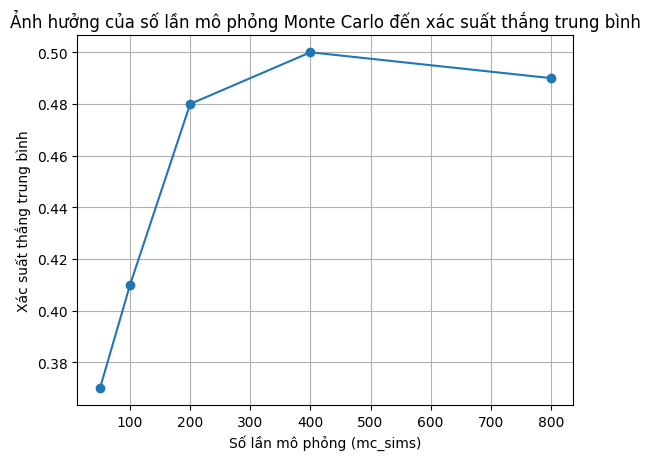 
-> Không gian mẫu càng lớn, độ chính xác càng lớn


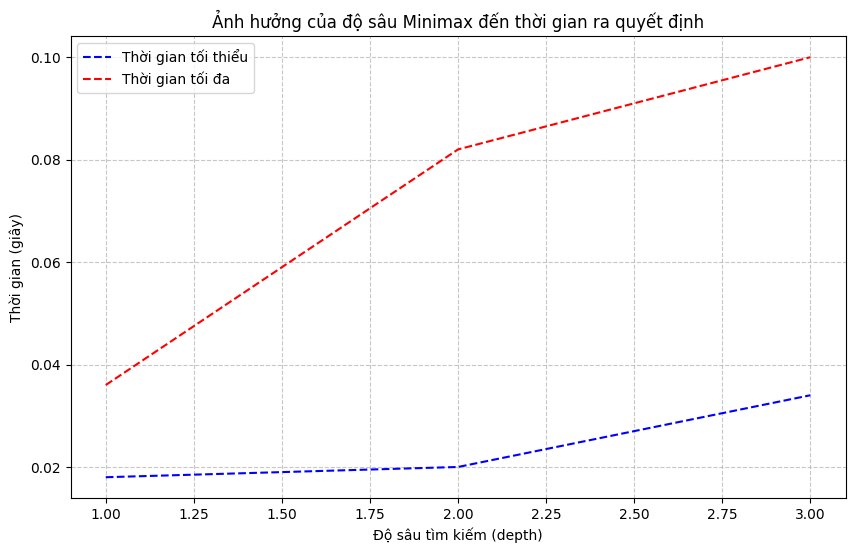
độ sâu càng lớn, thời gian càng lâu

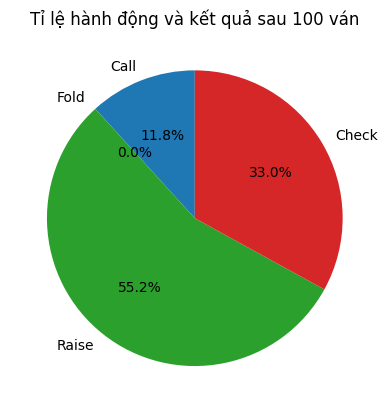
Bot còn quá láo

### Nhiệm vụ kế tiếp
Hoàn thiện hàm minimax chỉn chu hơn, sao cho xác suất chính xác hơn


## 4. Cập nhật kết quả cuối kỳ (W15)

### Chi tiết phương pháp, dữ liệu 
....

### Chương trình
...

### Phân tích, đánh giá kết quả
...

### Cập nhật phân công, khối lượng công việc
<!-- công việc của các thành viên, tỷ lệ đóng góp của các thành viên -->
...